*Josh Albano, Sharon Jan, and Luke Sherman (that's me)*

*2020.5.6*

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pandas.plotting import register_matplotlib_converters

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import re

from IPython.display import display, Latex, Markdown

### Research Question: Can counties' responses to COVID-19 accurately predict various political features?

Workplan:
- Clean data (Sharon)
    - Examine NA values
    - Election data (Josh)
- Define political features (county-level)
    - Republican/Democratic governor (binary) (Sharon)
    - Joshua's R/D scale (categorical) (Josh)
    - % of counties that are Republican (Sharon)
- Define potential COVID-19 features
    - Google's mobility rating (Josh)
    - Date of stay at home orders, relative to a case threshold (Luke)
        - Should we transform the case threshold to per capita
    - "Performance" - Beta_2 for quadratic model (Luke)
    - County enacted order earlier than state? or median date? OR estimate using decrease in mobility data
- Create model(s)
    - Logistic, Decision Tree, Linear (respectively) *hold off until done with initial data cleaning/feature engineering
- Data visualizations
    - Polarity/political maps (Josh)
    - Covid curves (Luke)

# Load Datasets

### Datasets
- states_df = State features dataframe
- counties_df = County features dataframe (missing some counties, Alaska, and Hawaii)
- time_cases_df = Timeline of cases by county
- time_deaths_df = Timeline of deaths by county
- state_time_cases_df = Timeline of cases by state
- state_time_deaths_df = Timeline of deaths by state


### Cleaning steps
- Get rid of all non-US states (including territories & cruise ships).
- Get rid of Alaska & Hawaii in states, time_cases, and time_deaths because it is not in counties_df
- In time_cases & time_deaths, there are 'Out of State' & 'Unassigned' observations that seem like they're state-level. We split those off from the county-specific information for now.
- Convert FIPS columns to strings so they can be used as a merge key later. 
- Rename state FIPS "STATEFP" and county FIPS remains "FIPS"
- Notes:  time_deaths_df & time_cases_df has about 30 counties in Virginia that aren't in counties_df. These counties have not been removed from time_deaths_df or time_cases_df yet.

In [198]:
#Datasets

states_df = pd.read_csv("4.18states.csv")
states_df = states_df[states_df['FIPS'].notna()] #Get rid of non-US "states"
states_df = states_df[states_df['FIPS']<60] #Get rid of US territories
states_df = states_df[states_df['FIPS'] != 2] #Get rid of Alaska
states_df = states_df[states_df['FIPS'] != 15] #Get rid of Hawaii
states_df['FIPS'] = states_df['FIPS'].apply(lambda x: '0'+str(int(x)) if len(str(int(x)))==1 \
                                            else str(int(x))) #Convert FIPS to String
states_df = states_df.rename(columns={'FIPS': 'STATEFP'})
STATEFP = states_df.pop('STATEFP')
states_df.insert(0, 'STATEFP', STATEFP)

counties_df = pd.read_csv("abridged_couties.csv")
counties_df = counties_df[counties_df['State'].notna()] #Get rid of US Territories
counties_df['STATEFP'] = counties_df['STATEFP'].apply(lambda x: '0'+str(int(x)) if len(str(int(x)))==1 else str(int(x)))
counties_df = counties_df.rename(columns={'countyFIPS': 'FIPS'}).drop(columns=['COUNTYFP'])

time_cases_df = pd.read_csv("time_series_covid19_confirmed_US.csv")
time_deaths_df = pd.read_csv("time_series_covid19_deaths_US.csv")

def clean_time_dfs(df):
    """
    This cleans time_cases & time_deaths and returns a county-level df and state-level df
    """
    df = df[df['FIPS'] >100] # Get rid of US Territories & Cruise Ships
    df = df[df['Province_State'].isin(['Diamond Princess','Grand Princess'])==False]
    df['FIPS'] = df['FIPS'].apply(lambda x: '0' + str(int(x)) if len(str(int(x)))==4 \
                                                    else str(int(x))) #Convert FIPS to string
    df['STATEFP'] = df['FIPS'].str[0:2]
    FIPS = df.pop('FIPS')
    df.insert(0, 'FIPS', FIPS)
    STATEFP = df.pop('STATEFP')
    df.insert(0, 'STATEFP', STATEFP)
    df = df[df['STATEFP'].isin(['02','15'])==False] #Get rid of Alaska & Hawaii
    #Split off "Out of [State]" & "Unassigned" Data. Remove from df
    state_df = df[df['STATEFP'].isin(['80','90'])]
    df = df[df['STATEFP'].isin(['80','90'])==False]
    return df, state_df

time_cases_df, state_time_cases = clean_time_dfs(time_cases_df)
time_deaths_df, state_time_deaths = clean_time_dfs(time_deaths_df)

## Josh's data - load here

In [ ]:
# load election, mobility data here

###  Train Test Split

This will be done on the state-level (i.e. 80/20 split of the states) and county-level (80/20 split on all counties)
* Please add any new dataframes

In [197]:
import sklearn.model_selection

def train_test_split_fips(unique_fips, fips_level, df_list):
    """
    Inputs:
    unique_fips = list of unique FIPS
    fips_level: either 'STATEFP' or 'FIPS'
    df_list: list of dataframes to train/test
    Returns:
    list of train/test splits of each dataframe: eg: [df1_train, df1_test, df2_train, df_test]
    """
    assert (fips_level == 'FIPS' or fips_level == 'STATEFP'), "Please enter 'STATEFP' or 'FIPS'for fips_level"

    #Train/Test Split FIPS IDs
    tr, te = sklearn.model_selection.train_test_split(
    unique_fips, train_size=0.8, test_size=0.2, random_state=47)
    
    tr_te_list = []
    
    # Create Train/Test list of DFs
    for df in df_list:
        tr_te_list.append(df[df[fips_level].isin(tr)])
        tr_te_list.append(df[df[fips_level].isin(te)])
        
    return tr_te_list

In [207]:
#Unique Fips Codes
statefp = states_df['STATEFP'].unique()
countyfp = counties_df['FIPS'].unique()

#DF List to Split
df_list = [states_df, counties_df, time_cases_df, time_deaths_df]

#State Level DFs
st_sl_test, st_sl_train, co_sl_test, co_sl_train, tc_sl_test, tc_sl_train, td_sl_test, td_sl_train = \
train_test_split_fips(statefp, 'STATEFP', df_list)

#County Level DFs (doesn't include states_df)
co_cl_test, co_cl_train, tc_cl_test, tc_cl_train, td_cl_test, td_cl_train = \
train_test_split_fips(countyfp, 'FIPS', df_list[1:4])

print("State-level test data consistent: ",set(st_sl_test.STATEFP) == \
      set(co_sl_test.STATEFP) == set(tc_sl_test.STATEFP) == set(td_sl_test.STATEFP))
print("State-level train data consistent: ",set(st_sl_train.STATEFP) == \
      set(co_sl_train.STATEFP) == set(tc_sl_train.STATEFP) == set(td_sl_train.STATEFP))
print("County-level test data consistent: ",
      set(co_cl_test.STATEFP) == set(tc_cl_test.STATEFP) == set(td_cl_test.STATEFP))
print("County-level train data consistent: ",
      set(co_cl_train.STATEFP) == set(tc_cl_train.STATEFP) == set(td_cl_train.STATEFP))

State-level test data consistent:  True
State-level train data consistent:  True
County-level test data consistent:  True
County-level train data consistent:  True


# EDA
## Taking a look at the dataset

Let's look at the distribution of stay at home orders by county:

Text(0.5, 1.0, 'Distribution of stay at home orders by US county')

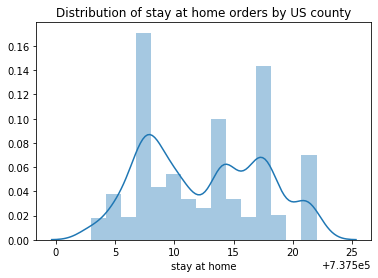

In [74]:
sns.distplot(counties_df["stay at home"].dropna())

plt.title("Distribution of stay at home orders by US county")

#I haven't figured out the date formatting here, but need to do that!

Text(0.5, 1.0, 'Cumulative cases since Feb')

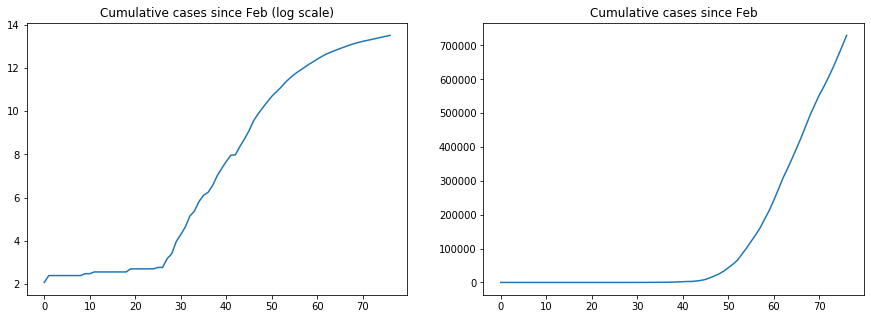

In [75]:
# Plot cumulative cases since February
us = time_cases_df.groupby("Country_Region").sum().iloc[:,15:].to_numpy().flatten()
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(0,len(us)), np.log(us))
ax[0].set_title("Cumulative cases since Feb (log scale)")
ax[1].plot(np.arange(0,len(us)), us)
ax[1].set_title("Cumulative cases since Feb")

Text(0.5, 1.0, 'Daily new cases since Feb')

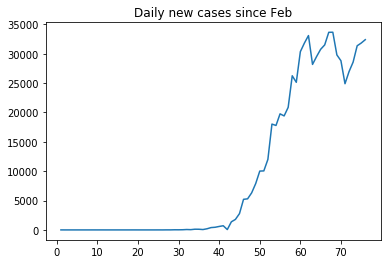

In [76]:
plt.plot(np.arange(1,len(us)), np.diff(us) )
plt.title("Daily new cases since Feb")

<BarContainer object of 76 artists>

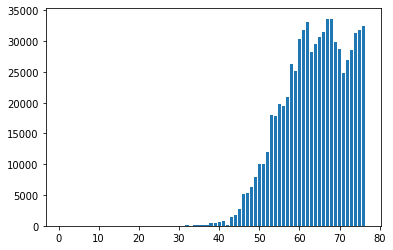

In [77]:
# Same as above, but in bar graph form

plt.bar(np.arange(1,len(us)), np.diff(us) )

Okay, now what I really want to do is understand how "stay at home orders" impact the new daily cases by county.

In [251]:
# The date objects were extremely annoying, so I built this function to convert them to pandas

def convert_ordinal_date_series_to_pd_date(series_object):
    """
    This function takes a series object of ordinal dates (days from the beginning of the 
    Gregorian calendar) and returns a pandas date time object series
    """
    
    #series_object = series_object.astype(int)
    k = []
    y = 0
    
    for ordinal_date in series_object:
        if np.isnan(ordinal_date) == True:
            y += 1
            k.append(np.nan)
            
        else:
            ordinal_date = int(ordinal_date)
            k.append(pd.to_datetime(datetime.datetime.fromordinal(ordinal_date)))
    print("Your series has", y, "NaNs. This function converts them to NaTs.")
    return pd.Series(k, index = series_object.index)

# Sharon's date conversion, returns df with new columns in M/D/Y time
def date_conversion(df, date_columns):
    """
    df - dataframe
    date_columns = list of column names (string type) to convert
    Returns dataframe with new column in mdy
    """
    for col in date_columns:
        df[col+' (mdy)'] = df[col].apply(lambda x: datetime.datetime.fromordinal(int(x)) if np.isnan(x) == False else x)
        
    return df

## Add Explanatory Features Here
- Earliest order in state (for all orders) (Sharon)
- Latest order in state (for all orders) (Sharon)
- Whether state had same order across the state (for all orders) (Sharon)
- County's order date relative to state (there's an issue here. It returns 0 even when the order value is NaN. I need to fix this!) (Sharon)

In [252]:
def state_orders_features(df, col, statefp= 'STATEFP'):
    """
    Inputs: df (dataframe), column (string of column name), statefp = STATEFP column
    Outputs a list of series: 
    1) The earliest date for the order, 
    2) The latest date for the order,
    3) Whether every county in the state has the same date of order (most likely a state order)
    4) Whether a county's order was before the median of the state (assuming the median will be the state order)
    """
    return [df[col].groupby(df[statefp]).transform(min),
            df[col].groupby(df[statefp]).transform(max),
            df[col].groupby(df[statefp]).transform(min) == df[col].groupby(df[statefp]).transform(max),
            df[col] - df[col].groupby(df[statefp]).transform('median')]

def add_state_orders_features_to_df(df, orders_columns, statefp = 'STATEFP'):
    """
    Adds state_orders_features to dataframe
    """
    for col in orders_columns:
        df['Earliest '+ col] = state_orders_features(df, col, statefp)[0]
        df['Latest '+ col] = state_orders_features(df, col, statefp)[1]
        df[col + ' same for whole state'] = state_orders_features(df, col, statefp)[2]
        df[col + ' relative to state'] = state_orders_features(df, col, statefp)[3]
    return df

In [253]:
# Apply state_orders_features and add_state_orders_features_to_df 
orders_columns = ['stay at home', '>50 gatherings',
       '>500 gatherings', 'public schools', 'restaurant dine-in',
       'entertainment/gym', 'federal guidelines', 'foreign travel ban']

order = '>50 gatherings'
counties_df = add_state_orders_features_to_df(counties_df, orders_columns)